<img src="mbit-logo.png" align="right" style="float" width="55">
<font color="#CA3532"><h1>RESUMEN PRÁCTICA PREPROCESADO DATOS EN PYTHON PARA MACHINE LEARNING (ENTRENAMIENTO/VALIDACIÓN MODELOS)</h1></font>


# IMPORTACIÓN DE LIBRERÍAS

In [1]:
# Paquetes de manipulación de datos y creación de gráficos:
%matplotlib inline
import pandas as pd 
import numpy as np
import scipy

# Paquetes de visualización:
import matplotlib.pyplot as plt
import seaborn as sns

# Librería de datasets
from sklearn import datasets
from sklearn.datasets import load_iris

# Utilidades de la librería de sklearn necesarias para técnicas de división de muestras (train/val/test):
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelos de aprendizaje automático de la librería sklearn:
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Métricas:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# Librería de preprocesado:
from sklearn import preprocessing

# Librería de pipeline:
from sklearn.pipeline import make_pipeline

# Librerías para ajuste de parámetros:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Gestión de warnings:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# IMPORTACIÓN Y PREPARACIÓN DEL CONJUNTO DE DATOS

In [2]:
# Importación de fichero CSV, categorizando algunas variables y cambiando las de valor "yes/no" a int64 (dicotómicas):
df_bank = pd.read_csv('./bank.csv', 
                      dtype={'job':'category',
                             'marital':'category',
                             'education':'category',
                             'contact':'category',
                             'month':'category',
                             'poutcome':'category'
                            },
                      converters = {'default': lambda x: 0 if x == "no" else 1,
                                    'housing': lambda x: 0 if x == "no" else 1,
                                    'loan': lambda x: 0 if x == "no" else 1,
                                    'y': lambda x: 0 if x == "no" else 1}
                      
                     )

# Hacemos una copia del dataframe para optimizar código:
df_test = df_bank.copy()

# Renombramos como TARGET la variable objetivo:
df_test = pd.DataFrame(df_test.rename(columns={'y':'TARGET'}))


### IMPUTACIÓN MISSING VALUES

In [3]:
# Imputamos los valores ausentes del dataset con uno de los métodos que incluye el paquete pandas (ffill):
df_test.fillna(method = 'ffill', inplace = True)


### FILTRADO OUTLIERS

In [4]:
# Definimos una lista con las variables cuyos outliers queremos filtrar:
vars6sigma = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Filtramos los valores atípicos (outliers) de las variables anteriores mediante el método 6σ:
def remove_outliers_six_sigma(X):
    return X[abs(X - np.mean(X)) < 3 * np.std(X)]

for var in vars6sigma:
    df_test = pd.merge(df_test, pd.DataFrame(remove_outliers_six_sigma(df_test[var].values)), 
                   how = 'left', 
                   left_index = True, 
                   right_index = True).rename(columns={0: var + '_6_sigma'})

# Eliminamos las variables con outliers para quedarnos únicamente con las filtradas:
df_test = df_test.drop(vars6sigma, axis = 1)

# Renombramos las variables filtradas quitándoles el sufijo "_6_sigma":
df_test = pd.DataFrame(df_test.rename(columns={'age_6_sigma':'age',
                                               'balance_6_sigma':'balance',
                                               'duration_6_sigma':'duration',
                                               'campaign_6_sigma':'campaign',
                                               'pdays_6_sigma':'pdays',
                                               'previous_6_sigma':'previous'}))

# Imputamos de nuevo los Missing Values que hayan aparecido con el método ffill de pandas:
df_test.fillna(method = 'ffill', inplace = True)

# Cambiamos el tipo de esas variables (float64) a tipo integer (int64):
for i in vars6sigma:
    df_test[i] = df_test[i].astype(np.int64)


### SELECCIÓN VARIABLES EN FUNCIÓN DE APROXIMACIONES FILTER/WRAPPER

In [5]:
# Reordenamos las columnas de nuestro dataframe para que TARGET sea la última:
df_test = df_test[['age','job','marital','education','default','balance','housing','loan','contact','day','month',
                   'duration','campaign','pdays','previous','poutcome','TARGET']]

# Por último, nos quedamos con las SEIS VARIABLES seleccionadas según el apartado anterior para entrenar el modelo. 
# NOTA: ver el análisis completo en el notebook de la práctica.
df_test = df_test.drop(['age','job','marital','education','contact','day','month','pdays','previous','poutcome'], axis = 1)

# YA TENEMOS NUESTRO DATASET PREPARADO:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   default   4521 non-null   int64
 1   balance   4521 non-null   int64
 2   housing   4521 non-null   int64
 3   loan      4521 non-null   int64
 4   duration  4521 non-null   int64
 5   campaign  4521 non-null   int64
 6   TARGET    4521 non-null   int64
dtypes: int64(7)
memory usage: 247.4 KB


# ENTRENAMIENTO Y VALIDACIÓN

### CONSTRUCCIÓN DE DATASETS DE ENTRENAMIENTO Y VALIDACIÓN

In [6]:
X = df_test.iloc[:,range(0,6)]
Y = df_test.iloc[:,6]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

### ENTRENAMIENTO Y VALIDACIÓN

In [8]:
clf = svm.SVC(gamma = 'auto').fit(X_train, y_train)
clf.score(X_test, y_test)

0.887988209285188

### ENTRENAMIENTO CON VALIDACIÓN CRUZADA: 10 iteraciones, métrica por defecto

In [9]:
clf = svm.SVC(gamma = 'auto')

scores1 = cross_val_score(clf, X, Y, cv = 10)
scores1

array([0.88300221, 0.88495575, 0.88274336, 0.88495575, 0.88716814,
       0.88716814, 0.88495575, 0.88716814, 0.88495575, 0.88495575])

### ENTRENAMIENTO CON VALIDACIÓN CRUZADA: iterador específico, métrica alternativa

In [10]:
skf = StratifiedKFold(n_splits = 10)

scores2 = cross_val_score(clf, X, Y, cv = skf, scoring = 'recall_weighted')
scores2

array([0.88300221, 0.88495575, 0.88274336, 0.88495575, 0.88716814,
       0.88716814, 0.88495575, 0.88716814, 0.88495575, 0.88495575])

### CROSS-VALIDATE CON DOS MÉTRICAS (SIN/CON EVALUACIÓN DEL CONJUNTO DE ENTRENAMIENTO)

In [11]:
# PRIMERO HACEMOS LA VALIDACIÓN CRUZADA CON DOS MÉTRICAS SIN EVALUACIÓN DEL TRAINING SET (return_train_score = false):

scoring = ['accuracy', 'recall_weighted']

scores3 = cross_validate(clf, X, Y, scoring = scoring, cv = 10, return_train_score = False)

print(sorted(scores3.keys()))
print('')
print(scores3['test_recall_weighted'])

['fit_time', 'score_time', 'test_accuracy', 'test_recall_weighted']

[0.88300221 0.88495575 0.88274336 0.88495575 0.88716814 0.88716814
 0.88495575 0.88716814 0.88495575 0.88495575]


In [12]:
# A CONTINUACIÓN HACEMOS LA VALIDACIÓN CRUZADA CON EVALUACIÓN DEL TRAINING SET (return_train_score = true):

scores4 = cross_validate(clf, X, Y, scoring = scoring, cv = 10, return_train_score = True)

print(sorted(scores4.keys()))
print('')
print(scores4['test_recall_weighted'])

['fit_time', 'score_time', 'test_accuracy', 'test_recall_weighted', 'train_accuracy', 'train_recall_weighted']

[0.88300221 0.88495575 0.88274336 0.88495575 0.88716814 0.88716814
 0.88495575 0.88716814 0.88495575 0.88495575]


### X-VALIDATION CON ITERADOR ESPECÍFICO, DOS MÉTRICAS y EVALUACIÓN DEL SET DE TRAINING

In [13]:
scores5 = cross_validate(clf, X, Y, scoring = scoring, cv = skf, return_train_score = True)

print(sorted(scores5.keys()))
print()
print(scores5['test_recall_weighted'])

['fit_time', 'score_time', 'test_accuracy', 'test_recall_weighted', 'train_accuracy', 'train_recall_weighted']

[0.88300221 0.88495575 0.88274336 0.88495575 0.88716814 0.88716814
 0.88495575 0.88716814 0.88495575 0.88495575]


### PROCESADO CON PIPELINES Y ENTRENAMIENTO CON VALIDACIÓN CRUZADA

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C = 1))
clf.fit(X_train, y_train)
clf.score(X_test, y_test )

0.8843036109064112

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

skf = StratifiedKFold(n_splits = 10)

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C = 1))
cross_val_score(clf, X, Y, cv = skf)

array([0.88300221, 0.88495575, 0.88495575, 0.88495575, 0.88495575,
       0.88495575, 0.88495575, 0.88495575, 0.88495575, 0.88495575])

# COMPARACIÓN ENTRE DISTINTOS MODELOS

C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR: 0.884762 (0.014195)
LDA: 0.884762 (0.014195)


C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


KNN: 0.875472 (0.013110)
CART: 0.804031 (0.013346)
NB: 0.879012 (0.015147)


C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\calfo\Anaconda3\envs\env_prueba\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


SVM: 0.884762 (0.014195)


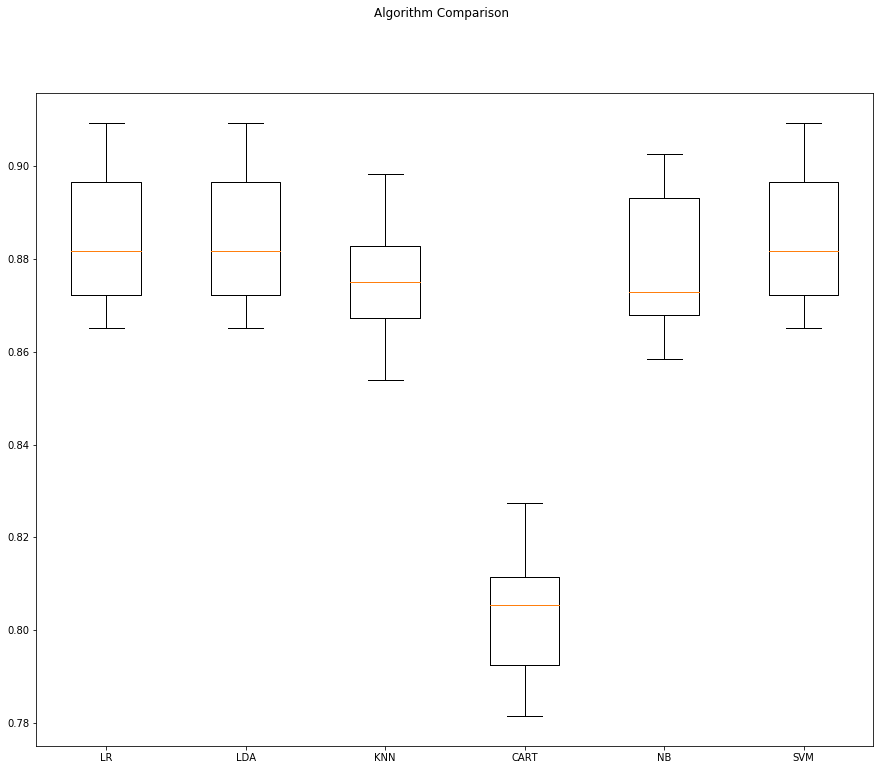

In [16]:
X = df_test.iloc[:,range(0,6)]
Y = df_test.iloc[:,6]

seed = 5

models = []
models.append(('LR'  , LogisticRegression        ()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier      ()))
models.append(('CART', DecisionTreeClassifier    ()))
models.append(('NB'  , GaussianNB                ()))
models.append(('SVM' , SVC                       ()))

results = []
names   = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.set_size_inches(15, 12)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()